# Figure

inspired by Fig. 3 of Naidu et al. (2020): https://ui.adsabs.harvard.edu/abs/2020ApJ...901...48N:

#### Author(s):
Sven Buder

#### History:
210329: Created

![title](literature/2014AJ....148...81M_Fig3.png)

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from sklearn import mixture

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

In [2]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits')

In [3]:
basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    np.isfinite(data['L_Z'])&
    np.isfinite(data['ecc'])    
    )
# in TOPCAT: flag_sp == 0 & flag_Mg_fe == 0 & abs(L_Z) >= 0

basic_cuts_mgnacu = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc'])&
    np.isfinite(data['age_bstep'])
    )
# in TOPCAT: flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0

In [4]:
import corner

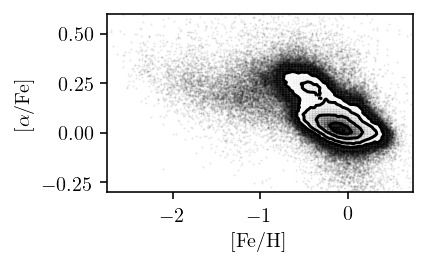

In [69]:
f, ax = plt.subplots(1,figsize=(3,2))

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    (data['snr_c2_iraf'] > 25) &
    np.isfinite(data['L_Z'])&
    np.isfinite(data['ecc'])    
    )

corner.hist2d(
    data['fe_h'][basic_cuts],
    data['alpha_fe'][basic_cuts],
    bins=100,
    ax=ax,
    data_kwargs=dict(ms=1.,alpha=0.1),
    range=[(-2.75,.75),(-0.3,0.6)]
)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'[$\alpha$/Fe]')
plt.tight_layout()
plt.savefig('tinsley_wallerstein.png',dpi=400,bbox_inches='tight')


In [60]:
def hist2d_elem_xfe(data, elem,x_lim=(-3,1),y_lim=(-3,3),a_x=False):
    selection = basic_cuts & (data['flag_'+elem+'_fe']==0)
    f,ax=plt.subplots(figsize=(3,2))
    if a_x:
        corner.hist2d(
            data['fe_h'][selection],
            data[elem+'_fe'][selection]+data['fe_h'][selection]+1.05,
            bins = (np.linspace(x_lim[0],x_lim[1],50),np.linspace(y_lim[0],y_lim[1],50)),
            ax=ax,
        )
        ax.set_ylabel('A('+elem+')')
    else:
#         ax.hist2d(
#             data['fe_h'][selection],
#             data[elem+'_fe'][selection],
#             bins = (np.linspace(x_lim[0],x_lim[1],50),np.linspace(y_lim[0],y_lim[1],50)),
#             norm=LogNorm()
#         )
        corner.hist2d(
            data['fe_h'][selection],
            data[elem+'_fe'][selection],
            bins = (np.linspace(x_lim[0],x_lim[1],50),np.linspace(y_lim[0],y_lim[1],50)),
            ax=ax,
        )
        ax.set_ylabel('['+elem+'/Fe]')
    ax.set_xlim(x_lim[0],x_lim[1])
    ax.set_ylim(y_lim[0],y_lim[1])
    ax.set_xlabel('[Fe/H]')

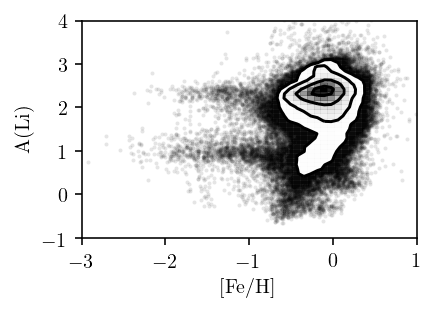

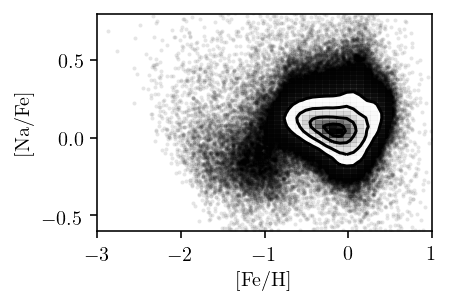

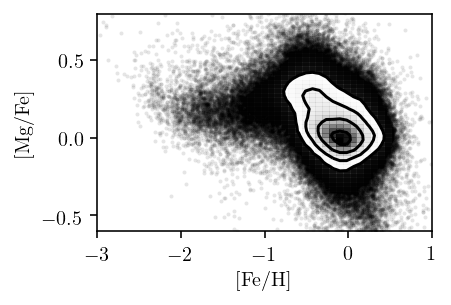

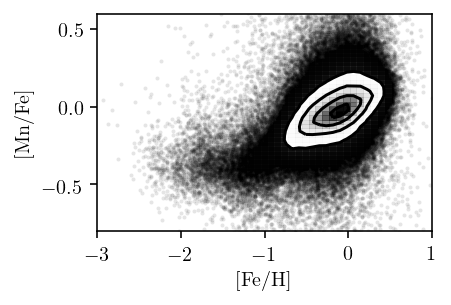

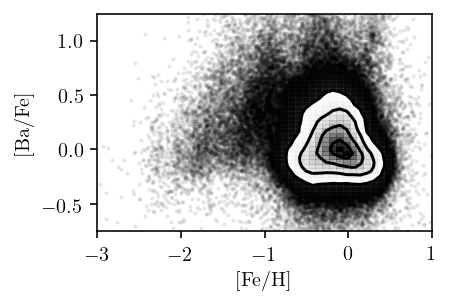

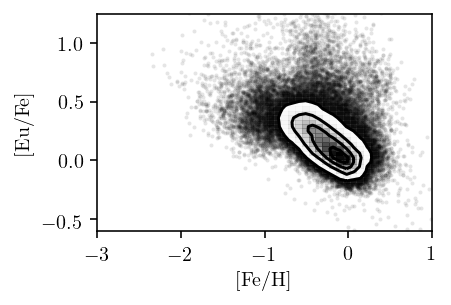

In [61]:
hist2d_elem_xfe(data, elem='Li',y_lim=(-1,4.0),a_x=True)
hist2d_elem_xfe(data, elem='Na',y_lim=(-0.6,0.8))
hist2d_elem_xfe(data, elem='Mg',y_lim=(-0.6,0.8))
hist2d_elem_xfe(data, elem='Mn',y_lim=(-0.8,0.6))
hist2d_elem_xfe(data, elem='Ba',y_lim=(-0.75,1.25))
hist2d_elem_xfe(data, elem='Eu',y_lim=(-0.6,1.25))

In [30]:
def plot_lz_e(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    p,x,y,s = ax.hist2d(
        data['L_Z']/(10**3),
        data['Energy']/(10**5),
        bins = (
            np.linspace(-4.0,5.0,100),
            np.linspace(-3.0,-0.5,100)
        ),
        cmin=1,norm=LogNorm()
    )
    ax.set_xlabel(r'$L_Z$ / $10^3\,\mathrm{kpc\,km\,s^{-1}}$')
    ax.set_ylabel(r'$E$ / $10^5\,\mathrm{km^{-2}\,s^{-2}}$')
    c = plt.colorbar(s,ax=ax)
    c.set_label('Nr. Spectra')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [6]:
def plot_vr_vpi(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    p,x,y,s = ax.hist2d(
        data['vR_Rzphi'],
        data['vT_Rzphi'],
        bins = (
            np.linspace(-400,400,100),
            np.linspace(-300,400,100)
        ),
        cmin=1,norm=LogNorm()
    )
    ax.set_xlabel(r'$V_R$ / $\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$V_\phi$ / $\mathrm{km\,s^{-1}}$')
    c = plt.colorbar(s,ax=ax)
    c.set_label('Nr. Spectra')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [7]:
def plot_jphijtot_jzjrjtot(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    p,x,y,s = ax.hist2d(
        data['L_Z']/(np.abs(data['J_R'])+np.abs(data['L_Z'])+np.abs(data['J_Z'])),
        (data['J_Z']-data['J_R'])/(np.abs(data['J_R'])+np.abs(data['L_Z'])+np.abs(data['J_Z'])),
        #data['L_Z']/np.sqrt((data['J_R'])**2+(data['L_Z'])**2+(data['J_Z'])**2),
        #(data['J_Z']-data['J_R'])/np.sqrt((data['J_R'])**2+(data['L_Z'])**2+(data['J_Z'])**2),
        bins = (
            np.linspace(-1.1,1.1,100),
            np.linspace(-1.1,1.1,100)
        ),
        cmin=1,norm=LogNorm()
    )
    ax.set_xlabel(r'$L_Z / J_\text{tot}$')
    ax.set_ylabel(r'$(J_Z - J_R) / J_\text{tot}$')
    c = plt.colorbar(s,ax=ax)
    c.set_label('Nr. Spectra')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [8]:
def plot_rgal_ecc(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    p,x,y,s = ax.hist2d(
        data['R_Rzphi'],
        data['ecc'],
        bins = (
            np.linspace(-0.1,15.1,100),
            np.linspace(-0.1,1.1,100)
        ),
        cmin=1,norm=LogNorm()
    )
    ax.set_xlabel(r'$R$ / $\mathrm{kpc}$')
    ax.set_ylabel(r'$e$')
    c = plt.colorbar(s,ax=ax)
    c.set_label('Nr. Spectra')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [9]:
def plot_feh_hist(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    ax.hist(
        data['fe_h'],
        bins = (
            np.linspace(-3.0,0.75,100)
        )
    )
    ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
    ax.set_ylabel('Nr. Spectra')
    ax.set_yscale('log')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

In [11]:
def plot_feh_mgfe(data,ax,sample_name,name_location='Title',panel='a)',cmap='Greys',logscale=True,cmap_up=False):
    if logscale:
        p,x,y,s = ax.hist2d(
            data['fe_h'],
            data['Mg_fe'],
            bins=(np.linspace(-2.0,0.75,150),np.linspace(-0.75,1.00,150)),
            cmin=1,norm=LogNorm()
        )
    else:
        p,x,y,s = ax.hist2d(
            data['fe_h'],
            data['Mg_fe'],
            bins=(np.linspace(-2.0,0.75,150),np.linspace(-0.75,1.00,150)),
            cmin=1
        )
    ax.set_xlabel(r'[Fe/H]')
    ax.set_ylabel(r'[Mg/Fe]')
    c = plt.colorbar(s,ax=ax)
    c.set_label('Nr. Spectra')
    ax.text(0.05,0.95,panel,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

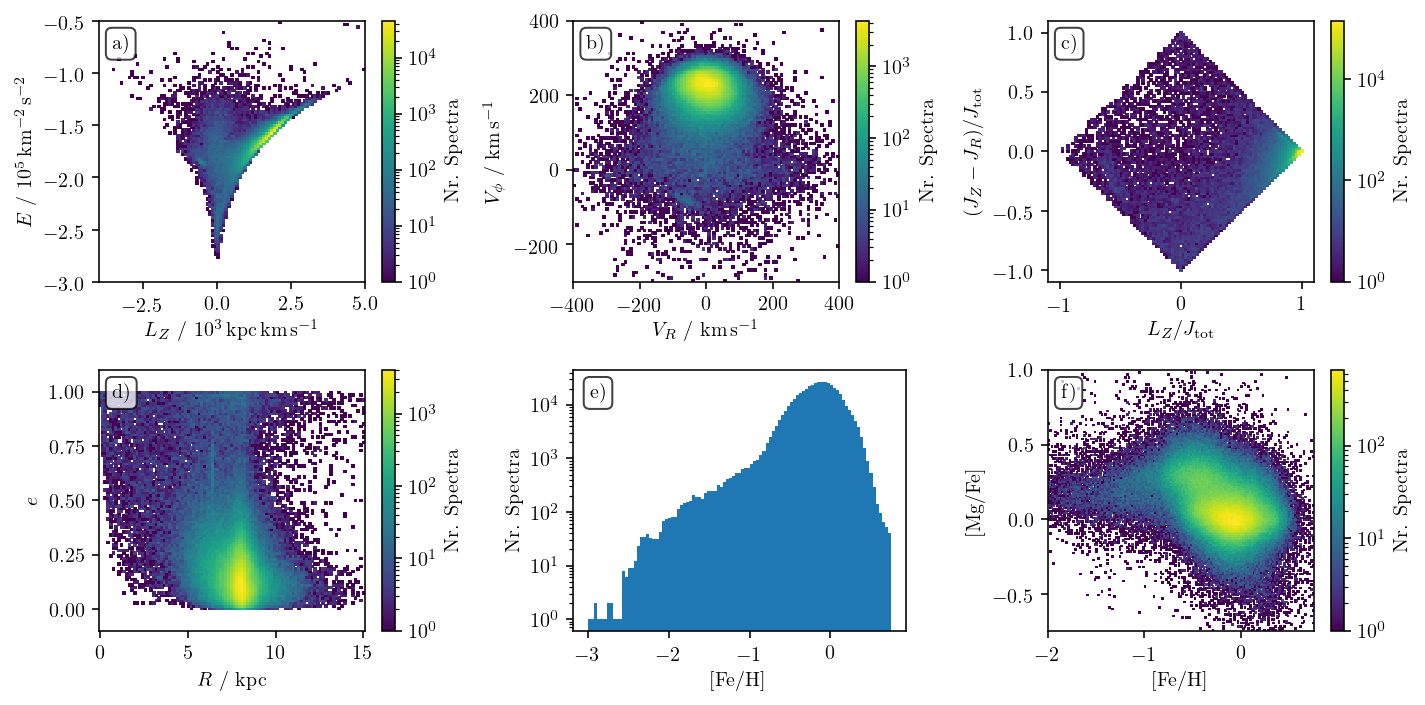

In [12]:
def plot_sample_overview(save=True):
    f, ax = plt.subplots(2,3,figsize=(10,5))
    
    plot_lz_e(data=data[basic_cuts], ax=ax[0,0], sample_name='Base sample', panel='a)')
    plot_vr_vpi(data=data[basic_cuts], ax=ax[0,1], sample_name='Base sample', panel='b)')
    plot_jphijtot_jzjrjtot(data=data[basic_cuts], ax=ax[0,2], sample_name='Base sample', panel='c)')
    plot_rgal_ecc(data=data[basic_cuts], ax=ax[1,0], sample_name='Base sample', panel='d)')
    plot_feh_hist(data=data[basic_cuts], ax=ax[1,1], sample_name='Base sample', panel='e)')
    plot_feh_mgfe(data=data[basic_cuts], ax=ax[1,2], sample_name='Base sample', panel='f)')
    
    plt.tight_layout()
    if save:
        plt.savefig('base_sample_overview.png',dpi=300,bbox_inches='tight')

plot_sample_overview()